# Goals of US Accidents dataset analysis

- Understanding factors that contribute to traffic accidents
- Building a predictive model for accident severity
- Identifying high-risk locations or conditions
- Creating visualizations of accident patterns
= Providing insights that could help reduce accidents


# Setting Up PySpark

In [1]:
# # # !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
# !tar xf spark-3.5.5-bin-hadoop3.tgz
# !pip install -q findspark

# Libraries

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler

# Loading Data

In [3]:
spark = SparkSession.builder \
    .appName("US Accidents Analysis") \
    .getOrCreate()

25/04/10 13:32:45 WARN Utils: Your hostname, lenovo-server resolves to a loopback address: 127.0.1.1; using 192.168.100.30 instead (on interface eno1)
25/04/10 13:32:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/10 13:32:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.format("csv") \
    .option("header", "True") \
    .option("inferSchema", "True") \
    .load("US_Accidents_March23.csv")

In [5]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [6]:
df.show(5)

25/04/10 13:33:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [7]:
print(f"Total number of records: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
print("Column names:", df.columns)

25/04/10 13:33:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Total number of records: 7728394
Number of columns: 46
Column names: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


# Data preprocess and clean

In [8]:
print("Missing values per column:")
for column_name, dtype in df.dtypes:
    if dtype in ("int", "double", "float"):
        # For numeric columns, check for nulls and NaN values
        missing_count = df.filter(F.col(column_name).isNull() | F.isnan(column_name)).count()
    else:
        # For non-numeric columns, only check for nulls and empty strings
        missing_count = df.filter(F.col(column_name).isNull() | (F.col(column_name) == "")).count()
    
    print(f"{column_name}: {missing_count}")

Missing values per column:


ID: 0


Source: 0


Severity: 0


Start_Time: 0


End_Time: 0


Start_Lat: 0


Start_Lng: 0


End_Lat: 3402762


End_Lng: 3402762


Distance(mi): 0


Description: 5


Street: 10869


City: 253


County: 0


State: 0


Zipcode: 1915


Country: 0


Timezone: 7808


Airport_Code: 22635


Weather_Timestamp: 120228


Temperature(F): 163853


Wind_Chill(F): 1999019


Humidity(%): 174144


Pressure(in): 140679


Visibility(mi): 177098


Wind_Direction: 175206


Wind_Speed(mph): 571233


Precipitation(in): 2203586


Weather_Condition: 173459


Amenity: 0


Bump: 0


Crossing: 0


Give_Way: 0


Junction: 0


No_Exit: 0


Railway: 0


Roundabout: 0


Station: 0


Stop: 0


Traffic_Calming: 0


Traffic_Signal: 0


Turning_Loop: 0


Sunrise_Sunset: 23246


Civil_Twilight: 23246


Nautical_Twilight: 23246


Astronomical_Twilight: 23246


# Dealing with missing values

## End_Lat and End_Lng Missing values

For End_Lat and End_Lng: Assuming, these are likely accidents where the endpoint wasn't recorded


Dropping these columns, fill with Start_Lat/Start_Lng, or keep nulls

In [9]:
df = df.withColumn("End_Lat", F.when(F.col("End_Lat").isNull(), F.col("Start_Lat")).otherwise(F.col("End_Lat")))
df = df.withColumn("End_Lng", F.when(F.col("End_Lng").isNull(), F.col("Start_Lng")).otherwise(F.col("End_Lng")))

##  Weather-related columns Missing Values

### Numeric

We have options:
- Fill with mean/median (for numeric data)
- Fill with a special value indicating "unknown"
- Leave as null for downstream processing

In [10]:
weather_numeric_cols = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", 
                        "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", 
                        "Precipitation(in)"]

for col in weather_numeric_cols:
    # Calculate mean excluding null values
    mean_val = df.select(F.mean(col)).collect()[0][0]
    # Replace nulls with the mean
    df = df.withColumn(col, F.when(F.col(col).isNull(), mean_val).otherwise(F.col(col)))

### Categorical

For categorical weather data, replacing missing with "Unknown"

In [11]:
df = df.withColumn("Weather_Condition", 
                  F.when(F.col("Weather_Condition").isNull(), "Unknown")
                   .otherwise(F.col("Weather_Condition")))

df = df.withColumn("Wind_Direction", 
                  F.when(F.col("Wind_Direction").isNull(), "Unknown")
                   .otherwise(F.col("Wind_Direction")))

## Twilight-related columns Missing Values

Filling with most frequent value

In [12]:
twilight_cols = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
for col in twilight_cols:
    # Fill with most frequent value
    most_common = df.groupBy(col).count().orderBy("count", ascending=False).first()[0]
    df = df.withColumn(col, F.when(F.col(col).isNull(), most_common).otherwise(F.col(col)))

## Other location based and description

In [13]:
df = df.withColumn("Street", F.when(F.col("Street").isNull(), "Unknown").otherwise(F.col("Street")))
df = df.withColumn("City", F.when(F.col("City").isNull(), "Unknown").otherwise(F.col("City")))
df = df.withColumn("Zipcode", F.when(F.col("Zipcode").isNull(), "Unknown").otherwise(F.col("Zipcode")))
df = df.withColumn("Airport_Code", F.when(F.col("Airport_Code").isNull(), "Unknown").otherwise(F.col("Airport_Code")))
df = df.withColumn("Timezone", F.when(F.col("Timezone").isNull(), "Unknown").otherwise(F.col("Timezone")))
df = df.withColumn("Description", F.when(F.col("Description").isNull(), "No description provided").otherwise(F.col("Description")))

## Missing Weather_Timestamp with Start_Time

In [14]:
df = df.withColumn("Weather_Timestamp", 
                  F.when(F.col("Weather_Timestamp").isNull(), F.col("Start_Time"))
                   .otherwise(F.col("Weather_Timestamp")))

## After Clean

In [15]:
print("Missing values after cleaning:")
for column_name in df.columns:
    missing_count = df.filter(F.col(column_name).isNull()).count()
    print(f"{column_name}: {missing_count}")

Missing values after cleaning:


ID: 0


Source: 0


Severity: 0


Start_Time: 0


End_Time: 0


Start_Lat: 0


Start_Lng: 0


End_Lat: 0


End_Lng: 0


Distance(mi): 0


Description: 0


Street: 0


City: 0


County: 0


State: 0


Zipcode: 0


Country: 0


Timezone: 0


Airport_Code: 0


Weather_Timestamp: 0


Temperature(F): 0


Wind_Chill(F): 0


Humidity(%): 0


Pressure(in): 0


Visibility(mi): 0


Wind_Direction: 0


Wind_Speed(mph): 0


Precipitation(in): 0


Weather_Condition: 0


Amenity: 0


Bump: 0


Crossing: 0


Give_Way: 0


Junction: 0


No_Exit: 0


Railway: 0


Roundabout: 0


Station: 0


Stop: 0


Traffic_Calming: 0


Traffic_Signal: 0


Turning_Loop: 0


Sunrise_Sunset: 0


Civil_Twilight: 0


Nautical_Twilight: 0


Astronomical_Twilight: 0


In [16]:
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|          End_Lat|           End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  

# Data Preprocessing

In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

This classification is crucial because each data type requires different preprocessing approaches.

In [18]:
categorical_cols = [
    "Source", "Severity", "State", "Country", "Timezone", "Weather_Condition", 
    "Wind_Direction", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", 
    "Astronomical_Twilight"
]

boolean_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", 
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", 
    "Traffic_Signal", "Turning_Loop"
]

numerical_cols = [
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Distance(mi)", 
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"
]

**Step 1: String Indexing**

This creates a collection of StringIndexer transformers that:
- Convert each text value in categorical columns to a numerical index
- Assign indices based on frequency (most frequent value gets index 0)
- Create new columns with suffix "_idx" containing these numerical indices
- Handle invalid or unseen values gracefully with the "keep" option

In [19]:
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") 
            for col in categorical_cols]

**Step 2: One-Hot Encoding**

This step transforms the indexed values into one-hot encoded vectors:
- Each category becomes a sparse vector (mostly zeros with a single 1)
- The vector length equals the number of unique values in the category
- The resulting columns have suffix "_ohe" (one-hot encoded)
- This transformation is essential as most ML algorithms cannot directly process categorical data

In [20]:
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe") 
            for col in categorical_cols]

**Feature Vector Creation**

**Step 3: Feature Column Collection**


This collects all processed feature column names that will be used to build the final feature vector:
- One-hot encoded categorical columns
- Original numerical columns
- Original boolean columns (already in 0/1 format)

In [21]:
feature_cols = [f"{col}_ohe" for col in categorical_cols] + numerical_cols + boolean_cols

**Step 4: Vector Assembly**

The VectorAssembler:
- Takes all individual feature columns
- Combines them into a single dense or sparse vector
- Creates a new column called "features" containing these vectors
- Properly handles any invalid values

In [22]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

**Feature Standardization**


This transformer standardizes the assembled feature vectors by:
- Subtracting the mean from each feature
- Dividing by the standard deviation
- Producing a new column "scaled_features" with standardized values
- Ensuring all features contribute equally to model learning regardless of their original scale

In [23]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

**Pipeline Construction**

The Pipeline combines all preprocessing steps into a single workflow:
1. First apply all string indexers to convert categories to numbers
2. Then apply all one-hot encoders to convert numbers to vectors
3. Assemble all features into a single vector
4. Scale the assembled vector

This ensures transformations are applied in the correct order and simplifies deployment.

In [24]:
from pyspark.ml import Pipeline

preprocessing_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
preprocessed_data = preprocessing_pipeline.fit(df).transform(df)
preprocessed_data.select("features", "scaled_features").show(5, truncate=True)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|(265,[1,4,25,56,5...|(265,[1,4,25,56,5...|
|(265,[1,3,25,56,5...|(265,[1,3,25,56,5...|
|(265,[1,3,25,56,5...|(265,[1,3,25,56,5...|
|(265,[1,4,25,56,5...|(265,[1,4,25,56,5...|
|(265,[1,3,25,56,5...|(265,[1,3,25,56,5...|
+--------------------+--------------------+
only showing top 5 rows



# Feature Engineering

In [25]:
from pyspark.sql.functions import hour, dayofweek, month, year
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import Correlation

## Time Based Features

In [26]:
df_fe = preprocessed_data.withColumn("Hour", hour(F.col("Start_Time")))
df_fe = df_fe.withColumn("DayOfWeek", dayofweek(F.col("Start_Time")))
df_fe = df_fe.withColumn("Month", month(F.col("Start_Time")))
df_fe = df_fe.withColumn("Year", year(F.col("Start_Time")))

## Distance-based features

In [27]:
df_fe = df_fe.withColumn("Is_Long_Distance", F.when(F.col("Distance(mi)") > 5, 1).otherwise(0))

## Weather severity feature

In [28]:
df_fe = df_fe.withColumn("Poor_Visibility", F.when(F.col("Visibility(mi)") < 5, 1).otherwise(0))
df_fe = df_fe.withColumn("Extreme_Temp", 
                         F.when((F.col("Temperature(F)") > 90) | (F.col("Temperature(F)") < 32), 1).otherwise(0))

## Updating

In [ ]:
new_numerical_cols = ["Hour", "DayOfWeek", "Month", "Year", "Is_Long_Distance", 
                      "Poor_Visibility", "Extreme_Temp"]

all_features = feature_cols + new_numerical_cols
new_assembler = VectorAssembler(inputCols=all_features, outputCol="features_engineered", handleInvalid="keep")

df_fe = new_assembler.transform(df_fe)

In [31]:
df_fe.select("Hour", "DayOfWeek", "Month", "Year", "Is_Long_Distance","Poor_Visibility", "Extreme_Temp").show(5, truncate=True)

+----+---------+-----+----+----------------+---------------+------------+
|Hour|DayOfWeek|Month|Year|Is_Long_Distance|Poor_Visibility|Extreme_Temp|
+----+---------+-----+----+----------------+---------------+------------+
|   5|        2|    2|2016|               0|              0|           0|
|   6|        2|    2|2016|               0|              0|           0|
|   6|        2|    2|2016|               0|              0|           0|
|   7|        2|    2|2016|               0|              0|           0|
|   7|        2|    2|2016|               0|              0|           0|
+----+---------+-----+----+----------------+---------------+------------+
only showing top 5 rows



- Created time-based features (Hour, DayOfWeek, Month, Year)
- Derived distance-based features (Is_Long_Distance)
- Generated weather severity indicators (Poor_Visibility, Extreme_Temp)
- Assembled engineered features into a comprehensive feature vector
- Performed feature selection to identify most important predictors
- Analyzed feature correlations to understand relationships

# Data Exploration (EDA)

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, desc, sum as spark_sum
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler

## Statistics and Data Distribution

In [37]:
print("Dataset Dimensions:")
print(f"Number of records: {df_fe.count()}")
print(f"Number of features: {len(df_fe.columns)}")

print("\nStatistical Summary of Numerical Columns:")
df_fe.select(numerical_cols).summary().show()

Dataset Dimensions:


Number of records: 7728394
Number of features: 78

Statistical Summary of Numerical Columns:


+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+
|summary|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|      Distance(mi)|   Temperature(F)|     Wind_Chill(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|  Wind_Speed(mph)|   Precipitation(in)|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+
|  count|           7728394|           7728394|           7728394|           7728394|           7728394|          7728394|           7728394|          7728394|           7728394|           7728394|          7728394|             7728394|
|   mean| 36.20119454946952|-94.70254538794683| 36.2

## Examining Accident Severity Distribution

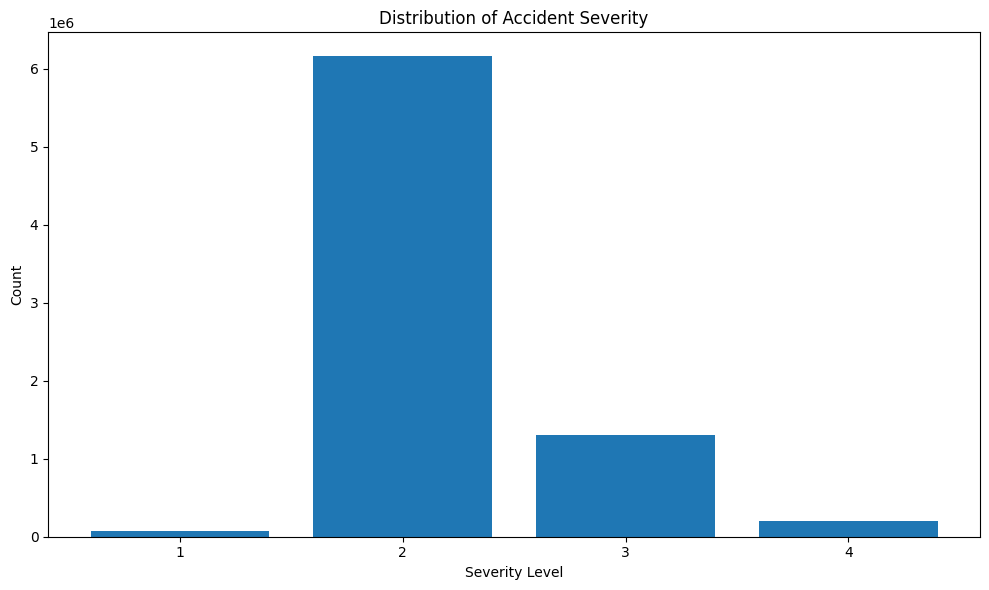

In [38]:
severity_counts = df_fe.groupBy("Severity").count().orderBy("Severity")
severity_pd = severity_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(severity_pd["Severity"].astype(str), severity_pd["count"])
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Temporal Analysis

### Hourly distribution

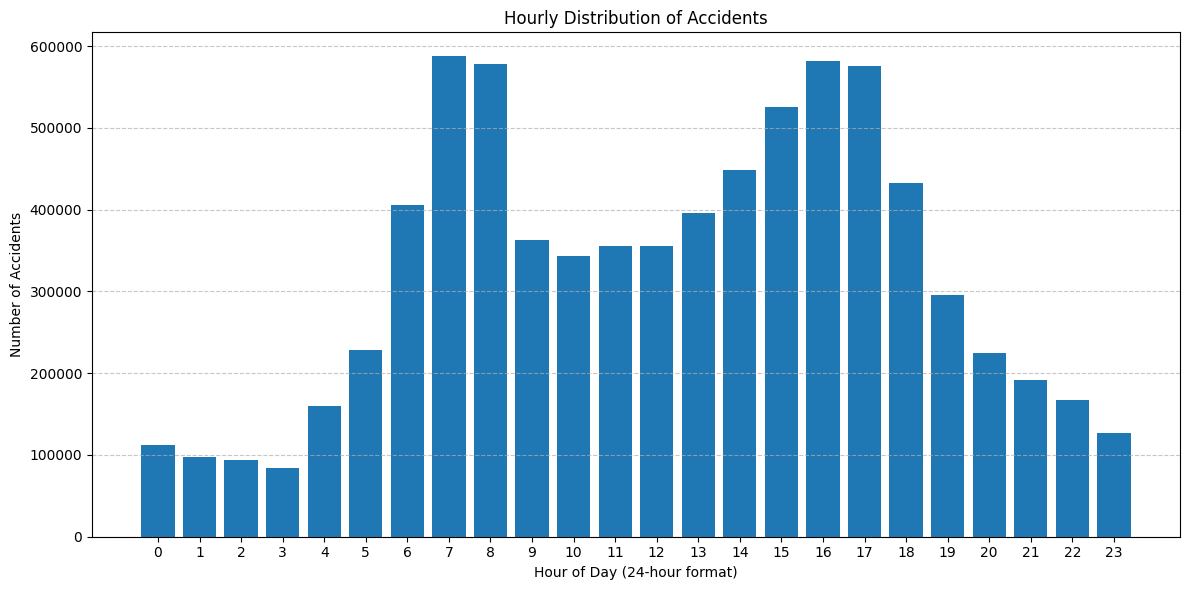

In [39]:
hourly_counts = df_fe.groupBy("Hour").count().orderBy("Hour")
hourly_pd = hourly_counts.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(hourly_pd["Hour"], hourly_pd["count"])
plt.title("Hourly Distribution of Accidents")
plt.xlabel("Hour of Day (24-hour format)")
plt.ylabel("Number of Accidents")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Day of week distribution

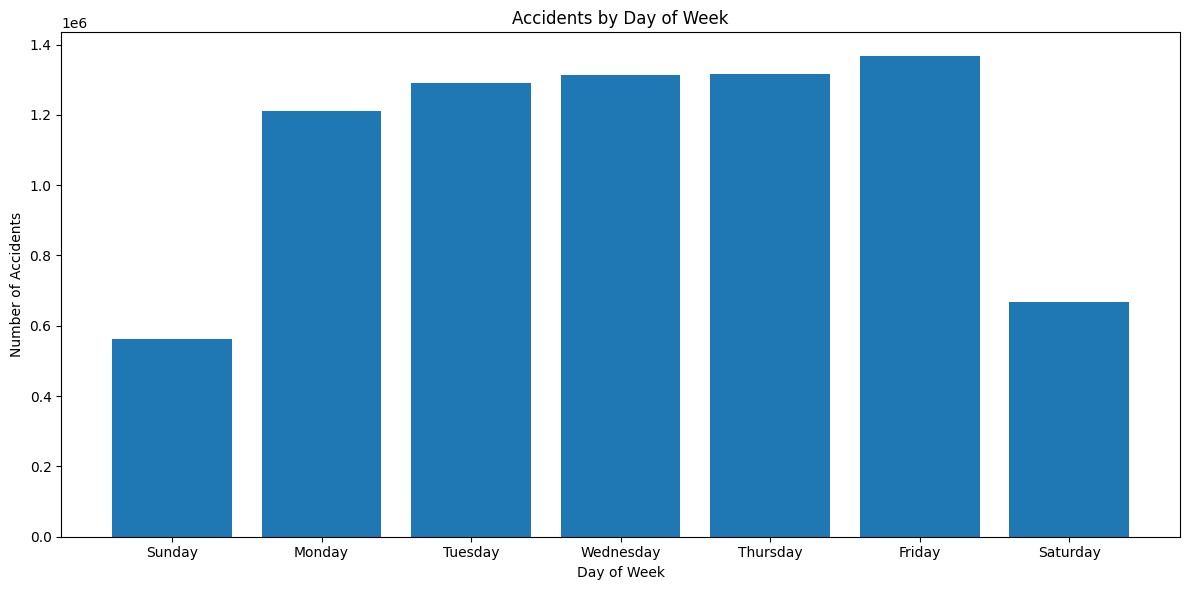

In [40]:
day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 
               5: "Thursday", 6: "Friday", 7: "Saturday"}
               
day_counts = df_fe.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
day_pd = day_counts.toPandas()
day_pd["DayName"] = day_pd["DayOfWeek"].map(day_mapping)

plt.figure(figsize=(12, 6))
plt.bar(day_pd["DayName"], day_pd["count"])
plt.title("Accidents by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

### Monthly distribution

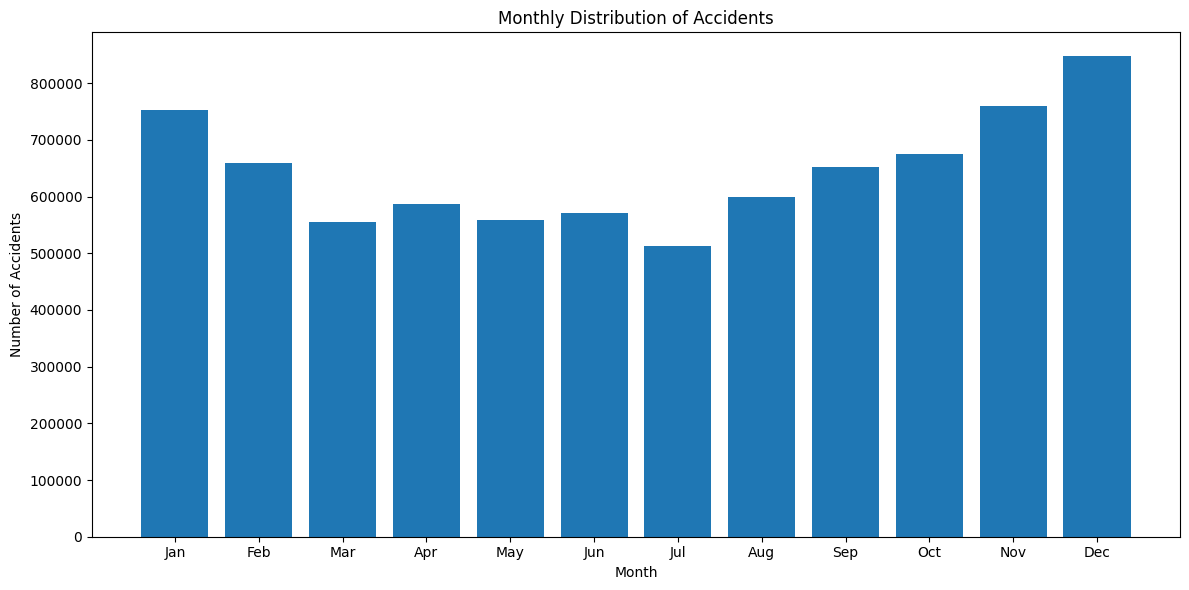

In [41]:
month_mapping = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
                 
month_counts = df_fe.groupBy("Month").count().orderBy("Month")
month_pd = month_counts.toPandas()
month_pd["MonthName"] = month_pd["Month"].map(month_mapping)

plt.figure(figsize=(12, 6))
plt.bar(month_pd["MonthName"], month_pd["count"])
plt.title("Monthly Distribution of Accidents")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

### Yearly trend

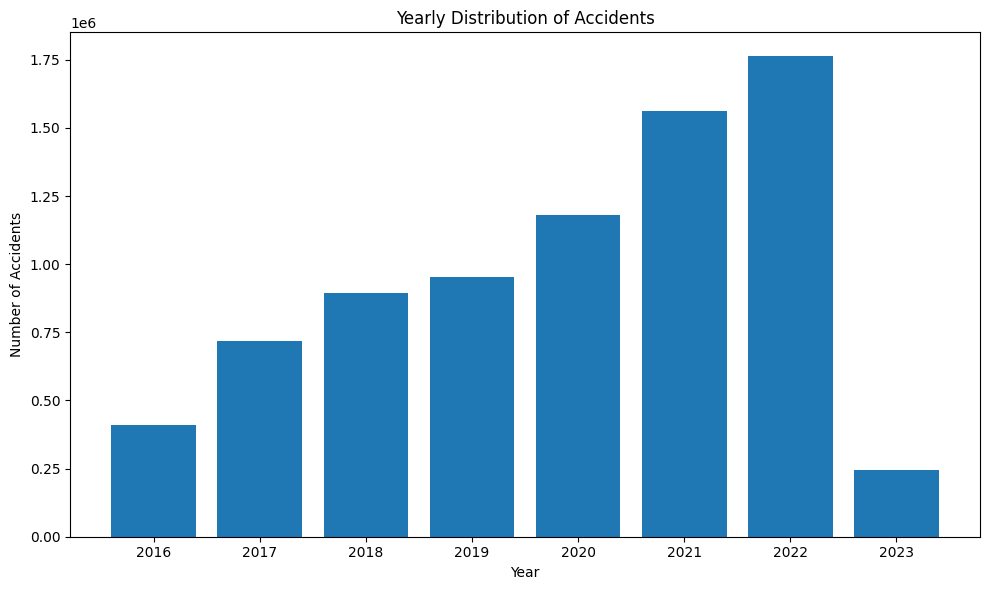

In [42]:
year_counts = df_fe.groupBy("Year").count().orderBy("Year")
year_pd = year_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(year_pd["Year"].astype(str), year_pd["count"])
plt.title("Yearly Distribution of Accidents")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

## Geographic Analysis

### Top 15 states with most accidents

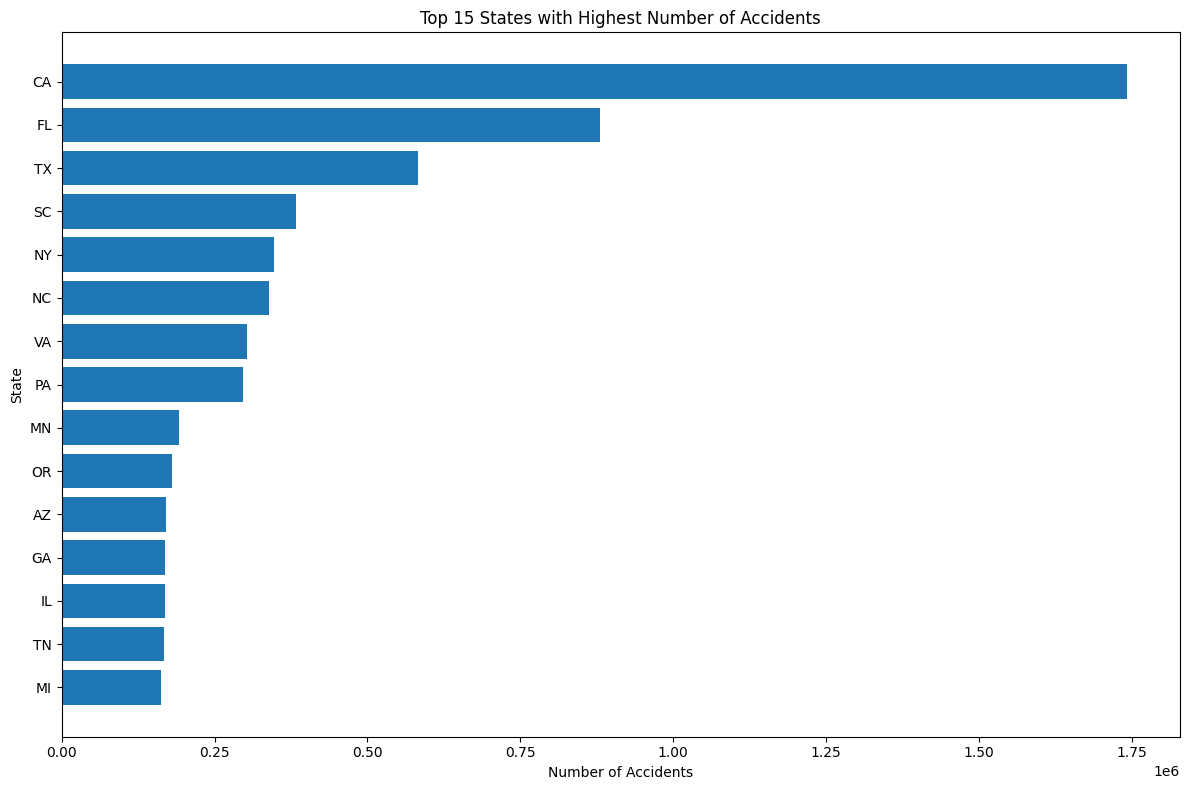

In [43]:
top_states = df_fe.groupBy("State").count().orderBy(desc("count")).limit(15)
top_states_pd = top_states.toPandas()

plt.figure(figsize=(12, 8))
plt.barh(top_states_pd["State"][::-1], top_states_pd["count"][::-1])
plt.title("Top 15 States with Highest Number of Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("State")
plt.tight_layout()
plt.show()


## Weather Condition Analysis

### Top weather conditions

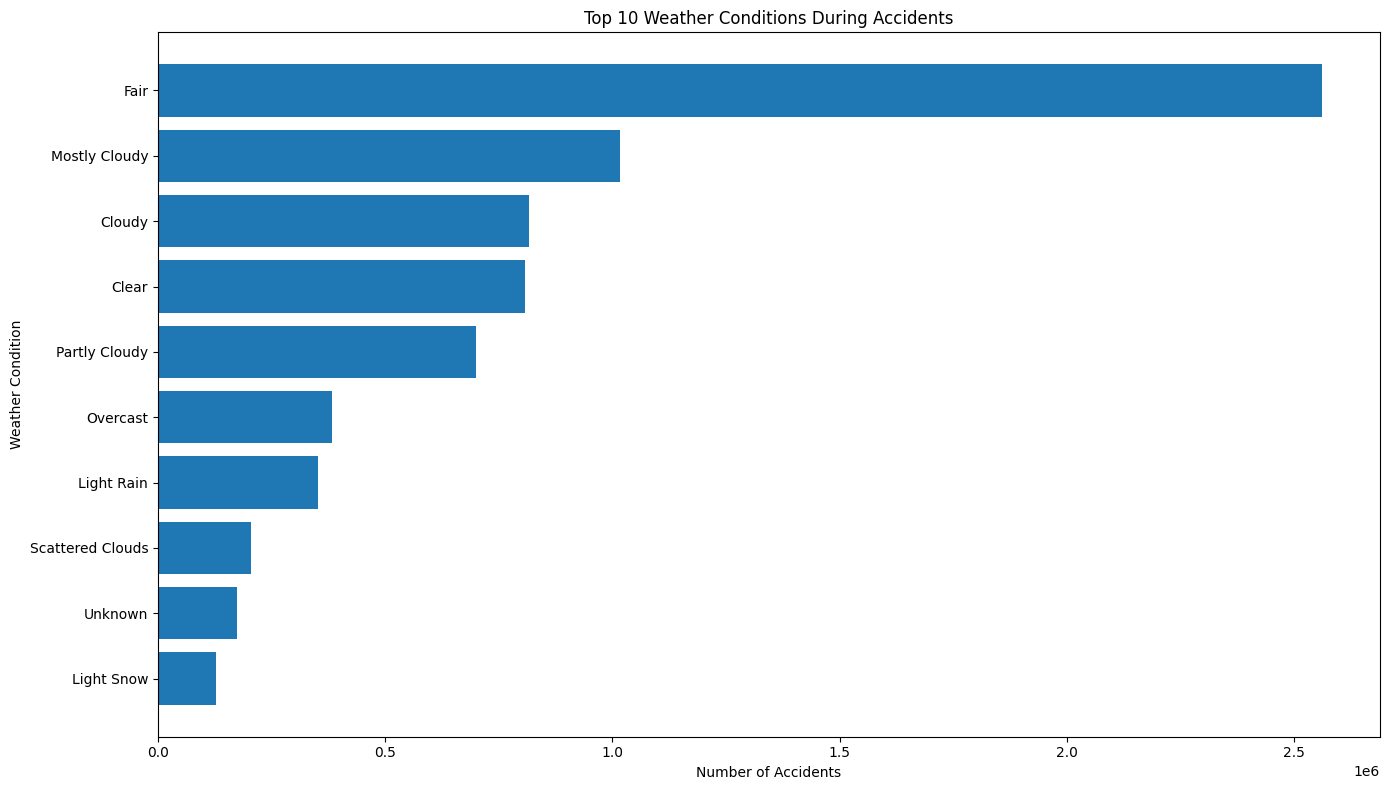

In [44]:
top_weather = df_fe.groupBy("Weather_Condition").count().orderBy(desc("count")).limit(10)
top_weather_pd = top_weather.toPandas()

plt.figure(figsize=(14, 8))
plt.barh(top_weather_pd["Weather_Condition"][::-1], top_weather_pd["count"][::-1])
plt.title("Top 10 Weather Conditions During Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.show()

### Temperature distribution

**Pipeline Construction**

The Pipeline combines all preprocessing steps into a single workflow:
1. First apply all string indexers to convert categories to numbers
2. Then apply all one-hot encoders to convert numbers to vectors
3. Assemble all features into a single vector
4. Scale the assembled vector

This ensures transformations are applied in the correct order and simplifies deployment.

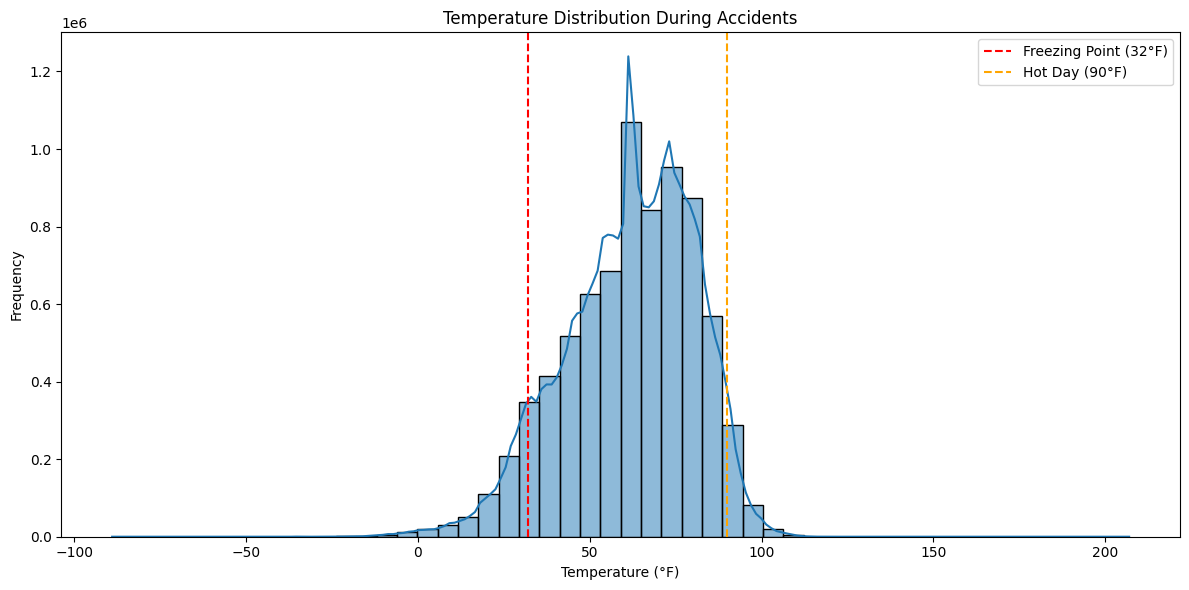

In [45]:
temp_data = df_fe.select("Temperature(F)").toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(temp_data["Temperature(F)"], bins=50, kde=True)
plt.title("Temperature Distribution During Accidents")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.axvline(x=32, color='r', linestyle='--', label="Freezing Point (32°F)")
plt.axvline(x=90, color='orange', linestyle='--', label="Hot Day (90°F)")
plt.legend()
plt.tight_layout()
plt.show()

## Road Features Analysis

### Road feature impact

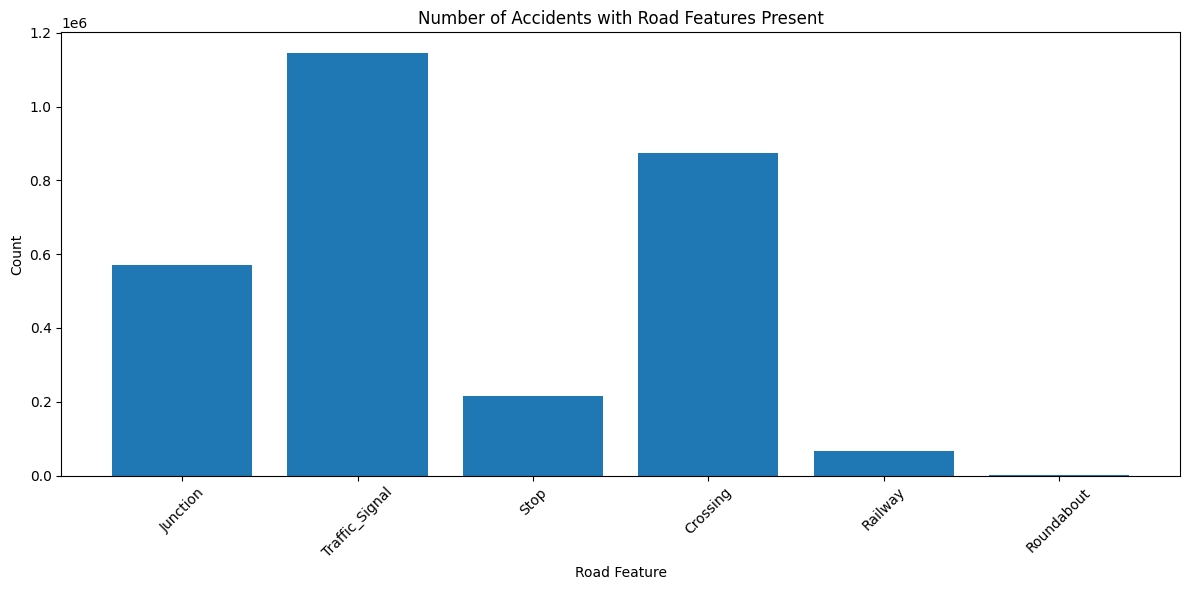

In [46]:
road_features = ["Junction", "Traffic_Signal", "Stop", "Crossing", "Railway", "Roundabout"]
feature_counts = {}

for feature in road_features:
    counts = df_fe.groupBy(feature).count().orderBy(feature).toPandas()
    if len(counts) == 2:  # Binary feature (0/1)
        feature_counts[feature] = counts.iloc[1]["count"]  # Count of "True" values

# Create bar chart of road features
plt.figure(figsize=(12, 6))
plt.bar(feature_counts.keys(), feature_counts.values())
plt.title("Number of Accidents with Road Features Present")
plt.xlabel("Road Feature")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Analysis

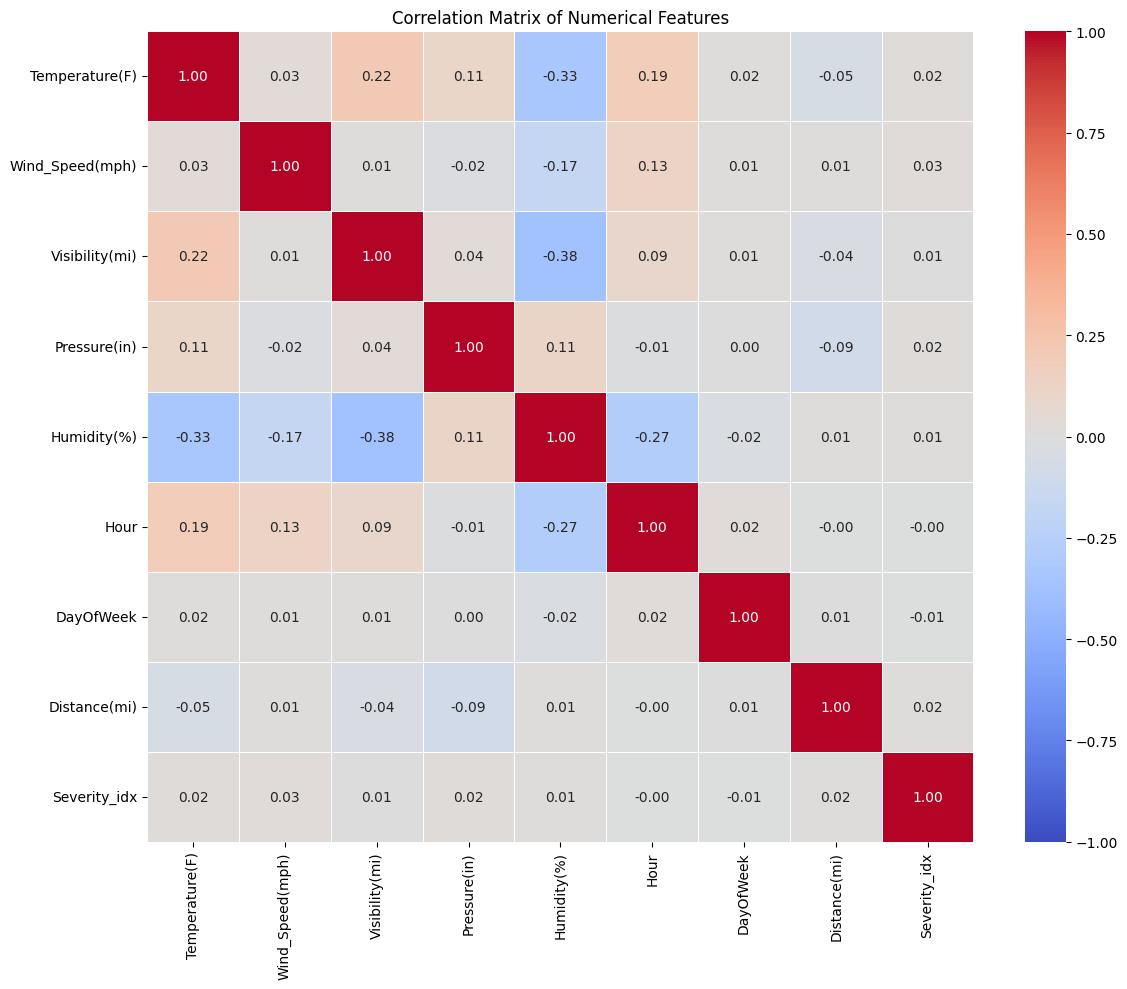

In [47]:
correlation_cols = ["Temperature(F)", "Wind_Speed(mph)", "Visibility(mi)", 
                    "Pressure(in)", "Humidity(%)", "Hour", "DayOfWeek", 
                    "Distance(mi)", "Severity_idx"]
correlation_assembler = VectorAssembler(
    inputCols=correlation_cols,
    outputCol="correlation_features",
    handleInvalid="skip"
)
correlation_df = correlation_assembler.transform(df_fe).select("correlation_features")

from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(correlation_df, "correlation_features").collect()[0][0]

# Convert Spark Matrix to numpy array
correlation_array = np.array(correlation_matrix.toArray())

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_array, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1,
    xticklabels=correlation_cols,
    yticklabels=correlation_cols
)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()



## Severity Analysis by Feature

### Severity by time of day

<Figure size 1400x800 with 0 Axes>

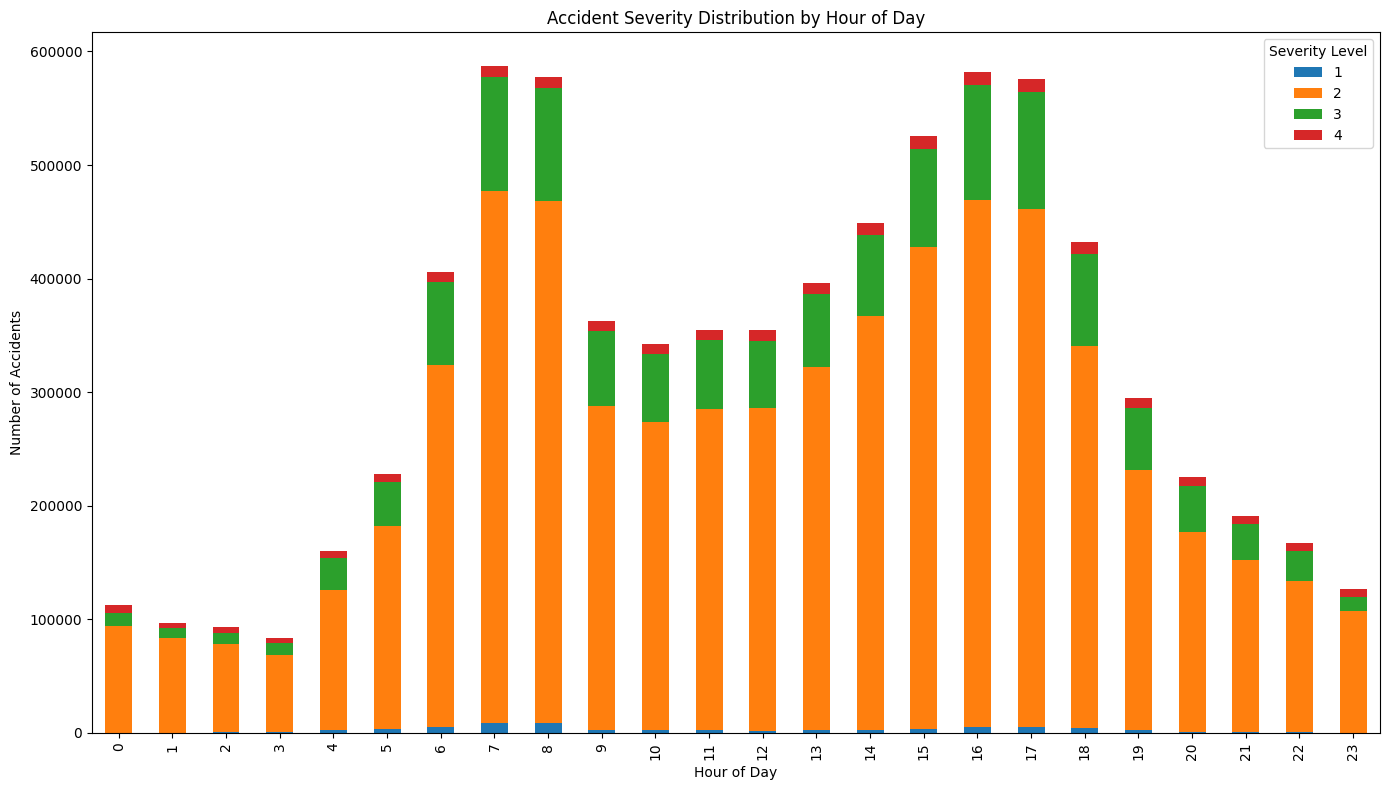

In [48]:
severity_by_hour = df_fe.groupBy("Hour", "Severity").count().orderBy("Hour", "Severity")
severity_hour_pd = severity_by_hour.toPandas()

# Pivot the data for stacked bar chart
severity_hour_pivot = severity_hour_pd.pivot(index="Hour", columns="Severity", values="count").fillna(0)

plt.figure(figsize=(14, 8))
severity_hour_pivot.plot(kind="bar", stacked=True, figsize=(14, 8))
plt.title("Accident Severity Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity Level")
plt.tight_layout()
plt.show()



## Analysis of Visibility and Its Impact

<Figure size 1000x600 with 0 Axes>

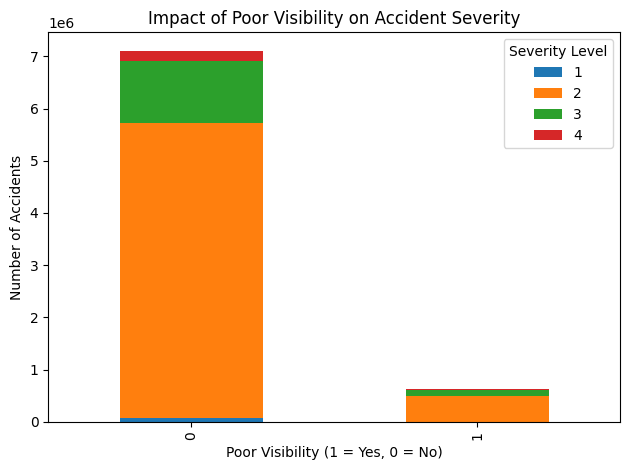

In [49]:
vis_severity = df_fe.groupBy("Poor_Visibility", "Severity").count().orderBy("Poor_Visibility", "Severity")
vis_severity_pd = vis_severity.toPandas()

# Create pivot table
vis_severity_pivot = vis_severity_pd.pivot(index="Poor_Visibility", columns="Severity", values="count").fillna(0)

plt.figure(figsize=(10, 6))
vis_severity_pivot.plot(kind="bar", stacked=True)
plt.title("Impact of Poor Visibility on Accident Severity")
plt.xlabel("Poor Visibility (1 = Yes, 0 = No)")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity Level")
plt.tight_layout()
plt.show()